# Resume Categorization with ML and NLP

I perform an exploratory analysis of the resume data to gain insights. I will try to address missing values and clean the text data. Next in this project, I apply TF-IDF (Term Frequency-Inverse Document Frequency) for text vectorization. Then I will split the dataset into training, validation, and testing subsets. Next stage is Model Training and Performance Evaluating, hence I will train an appropriate model based on the prepared data and evaluate the trained model via precision, recall, f1-score and accuracy. In the end, there will be a Python script for the automated categorization of resumes.

In [2]:
#import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

#classifier
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/radheyruparel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/radheyruparel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# load resume.csv dataset using by pandas.
data=pd.read_csv('Resume.csv')

# Split the data into train and test sets
resume_data, resume_test_data = train_test_split(data, test_size=0.15,stratify=data['Category'], random_state=42)

# Save the test data to CSV files
resume_test_data.to_csv('test_resume_data.csv', index=False)

In [4]:
resume_data.head()

ID                                         Resume_str  \
1443  16066857           SENIOR EXECUTIVE CHEF           Execu...   
56    52979663           SENIOR HR             Highlights     ...   
1131  15281412           CONSULTANT       Summary    Transitio...   
2472  16279537           SUPERVISORY LOGISTICS MANAGEMENT SPEC...   
1710  24647794           ENGINEERING INTERN           Profile ...   

                                            Resume_html     Category  
1443  <div class="fontsize fontface vmargins hmargin...         CHEF  
56    <div class="fontsize fontface vmargins hmargin...           HR  
1131  <div class="fontsize fontface vmargins hmargin...   CONSULTANT  
2472  <div class="fontsize fontface vmargins hmargin...     AVIATION  
1710  <div class="fontsize fontface vmargins hmargin...  ENGINEERING

In [5]:
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 1443 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2111 non-null   int64 
 1   Resume_str   2111 non-null   object
 2   Resume_html  2111 non-null   object
 3   Category     2111 non-null   object
dtypes: int64(1), object(3)
memory usage: 82.5+ KB


In [6]:
# Check how much data is available for our training model.
resume_data.shape

(2111, 4)

Now I want to check how many categories are in the Categories columns for our model.

In [7]:
resume_data['Category'].unique()

array(['CHEF', 'HR', 'CONSULTANT', 'AVIATION', 'ENGINEERING', 'BANKING',
       'BUSINESS-DEVELOPMENT', 'ADVOCATE', 'FINANCE', 'DIGITAL-MEDIA',
       'CONSTRUCTION', 'HEALTHCARE', 'DESIGNER', 'AGRICULTURE', 'ARTS',
       'FITNESS', 'TEACHER', 'PUBLIC-RELATIONS', 'APPAREL',
       'INFORMATION-TECHNOLOGY', 'ACCOUNTANT', 'SALES', 'BPO',
       'AUTOMOBILE'], dtype=object)

In [8]:
# check how many resume are available in every category.
resume_data['Category'].value_counts()


BUSINESS-DEVELOPMENT      102
INFORMATION-TECHNOLOGY    102
CHEF                      100
ENGINEERING               100
ADVOCATE                  100
FINANCE                   100
ACCOUNTANT                100
AVIATION                   99
SALES                      99
FITNESS                    99
CONSULTANT                 98
BANKING                    98
HEALTHCARE                 98
CONSTRUCTION               95
PUBLIC-RELATIONS           94
HR                         93
DESIGNER                   91
ARTS                       88
TEACHER                    87
APPAREL                    82
DIGITAL-MEDIA              82
AGRICULTURE                54
AUTOMOBILE                 31
BPO                        19
Name: Category, dtype: int64

In [9]:
len(resume_data['Category'].value_counts())

24

Out of 24 different categories, BUSINESS-DEVELOPMENT and INFORMATION-TECHNOLOGY class is the largest class with 102 resumes, whereas BPO class is the smallest with only 19 resumes. We have 100 resumes in some classes. Now I will develop a machine learning classifier which is going to correctly predict the class of an applicant's resume. Since we have 24 different categories, we will develop a multi-class classification algorithm.

# Exploratory Data Analysis
During the Exploratory Data Analysis (EDA) phase, we delve into the dataset to gain insights and comprehend its underlying patterns. This involves assessing basic statistics, visualizing data distributions, exploring correlations among variables, identifying potential outliers, and recognizing any initial trends that might guide our subsequent modeling and decision-making processes.

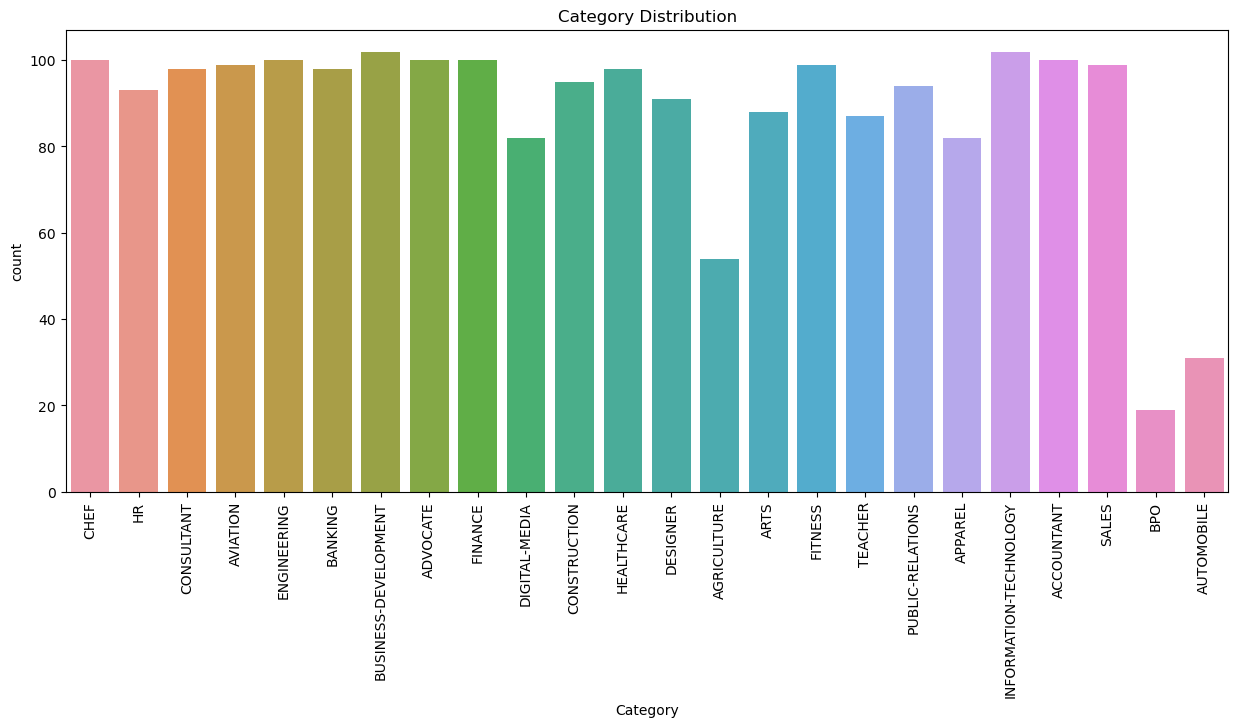

In [10]:
# Visualize the distribution of categories
plt.figure(figsize=(15, 6))
sns.countplot(x=resume_data['Category'])
plt.xticks(rotation=90)
plt.title('Category Distribution')
plt.show()

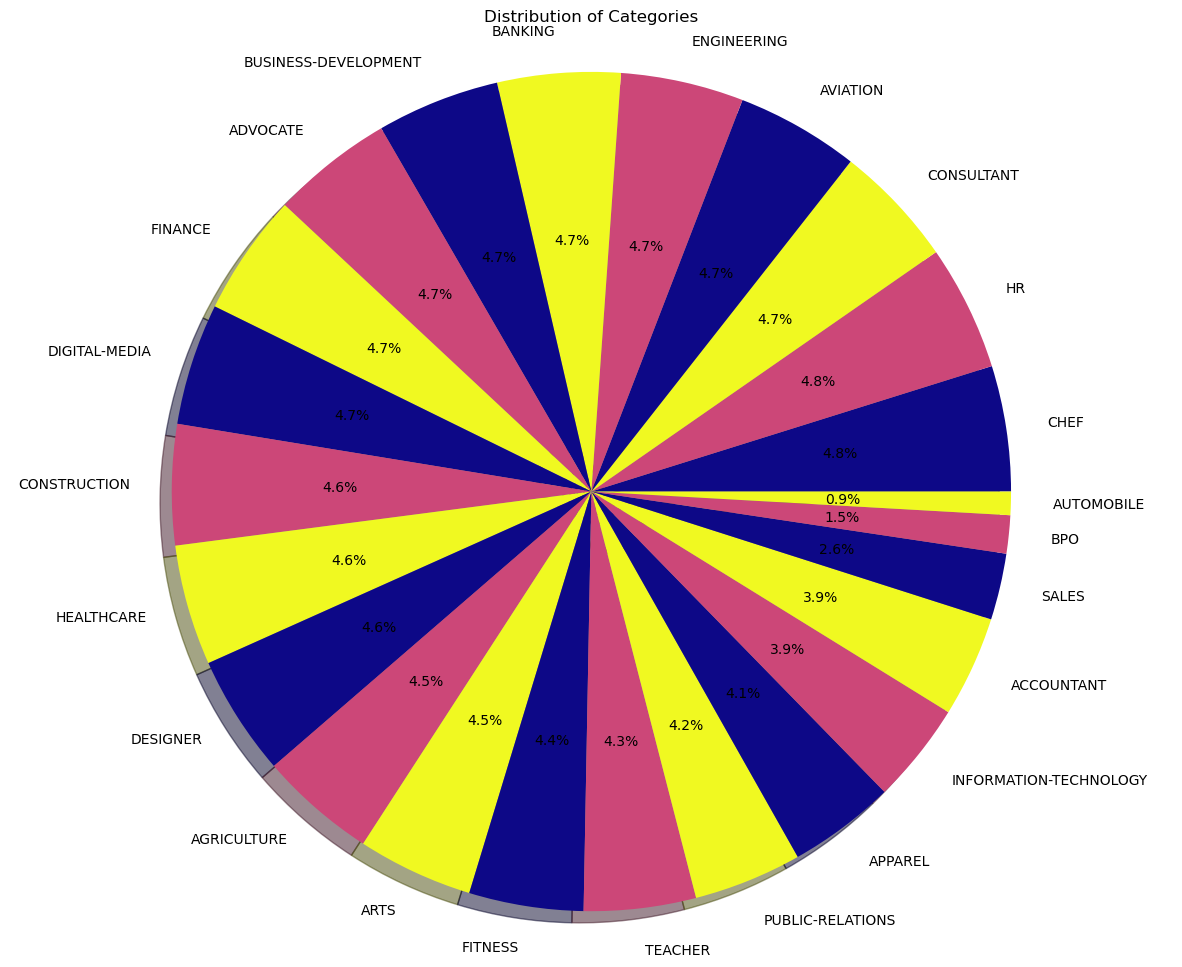

In [11]:
# create pie plot

counts=resume_data['Category'].value_counts()
labels=resume_data['Category'].unique()

plt.figure(figsize=(15,12))
plt.pie(counts,labels= labels, autopct='%1.1f%%',shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.title('Distribution of Categories')
plt.axis('equal')  
plt.show()

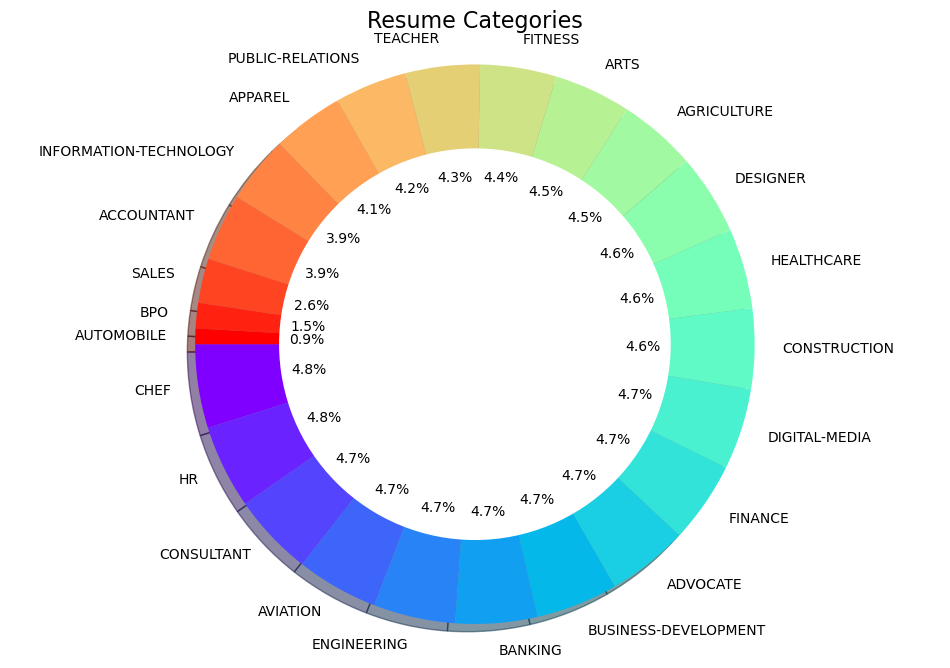

In [12]:
# Create a color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

# Create pie plot
plt.figure(figsize=(12, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors, startangle=180)

# Add a circle at the center to simulate depth perception
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.title("Resume Categories", fontsize=16)
plt.show()

In [14]:
import plotly.graph_objects as go

# Count the occurrences of each category
counts=resume_data['Category'].value_counts()
labels=resume_data['Category'].unique()

# Create a pie chart using Plotly
fig = go.Figure(data=[go.Pie(labels=labels, values=counts)])

# Set layout options
fig.update_layout(title='Resume Categories')

# Show the pie chart
fig.show()

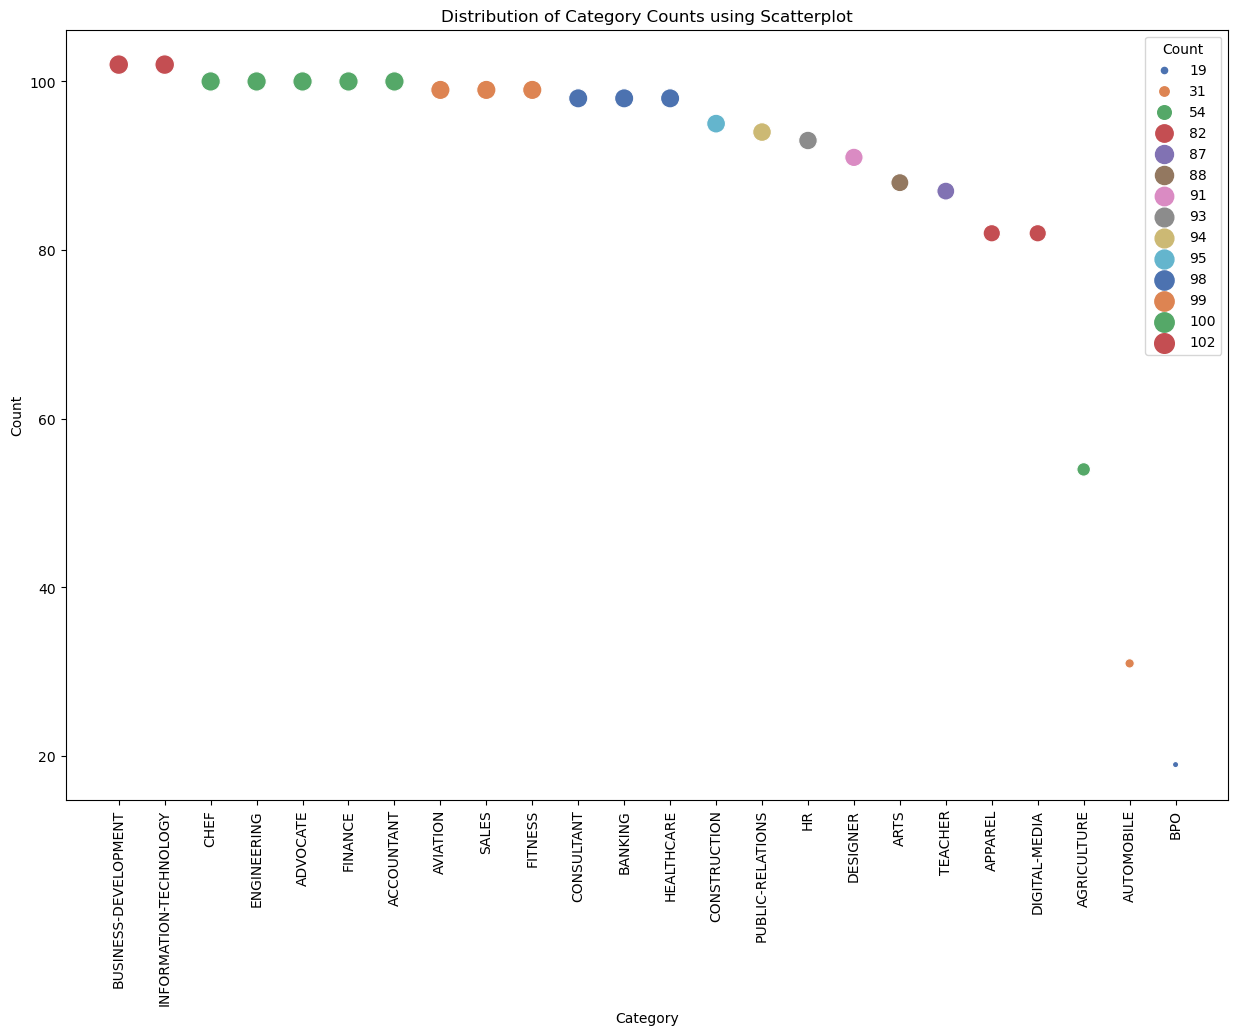

In [15]:
# Count the occurrences of each category
category_counts = resume_data['Category'].value_counts()

# Create a DataFrame with unique category names and their counts
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Category', 'Count']

# Create a violin plot
plt.figure(figsize=(15, 10))
sns.scatterplot(data=category_counts_df, x="Category", y="Count" ,size="Count",hue="Count", sizes=(20, 200), hue_norm=(0, 7), palette="deep",legend="full")
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Category Counts using Scatterplot')
plt.xticks(rotation=90)
plt.show()


Here we see that some categories contain a smaller number of resumes. maybe it's less than our predicted class label.

Let's create a word cloud for the category column and understand which are the most important.

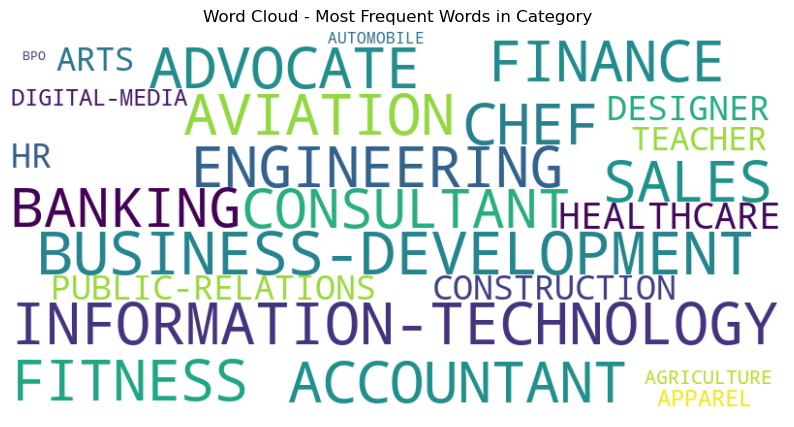

In [16]:
# Combine text from Category columns
combined_text = ' '.join(resume_data['Category'])

# Tokenize and count word frequency
word_counts = Counter(combined_text.split())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words in Category')
plt.show()

## Handling Missing Values and Text Cleaning

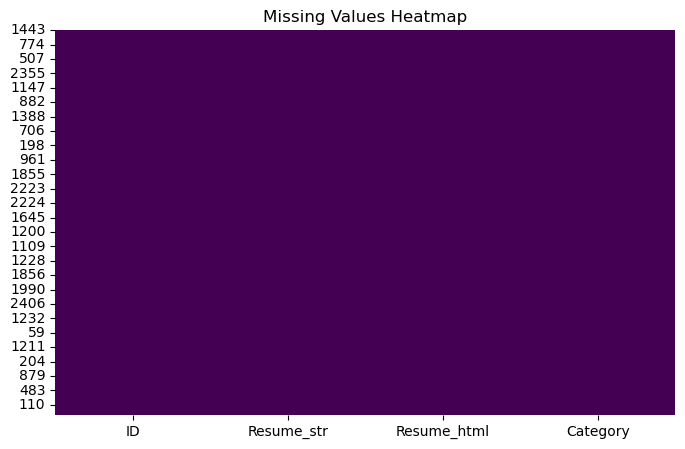

In [17]:
# Check for missing values
missing_values = resume_data.isnull().sum()

# Visualize missing values
plt.figure(figsize=(8, 5))
sns.heatmap(resume_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [18]:
resume_data.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

That means there are no missing values in our data set.

We need to apply some data cleaning before vectorizing our text data. Just a quick reminder, in NLP, we need to convert text data to numbers before applying any machine learning. That process is called the vectorization of the text data.

Let's have a quick look at one of the resumes to better understand what types of steps we need to perform.



In [19]:
# Check resume data in 'Resume_str' column to see the text cleaning approach
# Print the content of the first row in the 'Resume_str' column
print(resume_data['Resume_str'][0])

         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss preve

Now, we can observe the presence of unnecessary elements in the text data, including dots, commas, excessive spaces, consecutive underscores, links, numbers, and other extraneous characters.


### Cleaning function
This code performs the following steps:

Removes links (URLs) using regular expressions.
Removes punctuation and special characters using regular expressions.
Removes extra spaces and underscores.
Removes numbers using regular expressions.
Converts the text to lowercase.
Removes leading and trailing spaces.
Removes Stopwords.
and If someone is using the "Resume_html" column for this analysis, then he must clean html tags

Removes HTML Tags.

In [20]:
def resume_cleaning(text):
    
    # Remove HTML tags 
    cleaned_text = re.sub(r'<.*?>', ' ', text)
    
    # Remove non-english characters, punctuation,special characters, digits, continous underscores and extra whitespace
    cleaned_text = re.sub('[^a-zA-Z]', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]|_', ' ', cleaned_text)
    cleaned_text = re.sub(r'\d+', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text=re.sub('http\S+\s', " ", cleaned_text)
    
    
    
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    
    # Tokenize the cleaned text
    words = word_tokenize(cleaned_text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Tokenize the cleaned text
    words = word_tokenize(cleaned_text)
    
    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    cleaned_text = ' '.join(stemmed_words)
    
    return cleaned_text

Here I also did the stemming procedure. We know Stemming and lemmatization are important to text analysis work.

In [21]:
#now apply text cleaning function in my dataset
resume_data['Cleaned_Resume']=resume_data['Resume_str'].apply(lambda x:resume_cleaning(x))

In [22]:
resume_data.head()

ID                                         Resume_str  \
1443  16066857           SENIOR EXECUTIVE CHEF           Execu...   
56    52979663           SENIOR HR             Highlights     ...   
1131  15281412           CONSULTANT       Summary    Transitio...   
2472  16279537           SUPERVISORY LOGISTICS MANAGEMENT SPEC...   
1710  24647794           ENGINEERING INTERN           Profile ...   

                                            Resume_html     Category  \
1443  <div class="fontsize fontface vmargins hmargin...         CHEF   
56    <div class="fontsize fontface vmargins hmargin...           HR   
1131  <div class="fontsize fontface vmargins hmargin...   CONSULTANT   
2472  <div class="fontsize fontface vmargins hmargin...     AVIATION   
1710  <div class="fontsize fontface vmargins hmargin...  ENGINEERING   

                                         Cleaned_Resume  
1443  senior execut chef execut profil seek employ e...  
56    senior hr highlight safeti managementemploye e...  
1131  consult summari transit applic develop secur p...  
2472  supervisori logist manag specialist summari ta...  
1710  engin intern profil profici entri level electr...

Now, get the Cleaned_Resume column, which contains all cleaned text.

In [23]:
# check any internal pdf are empty or not after cleaning procedure.

empty_rows = resume_data[resume_data['Cleaned_Resume'] == '']
print(empty_rows)

           ID             Resume_str  \
656  12632728                          

                                           Resume_html              Category  \
656  <div class="fontsize fontface vmargins hmargin...  BUSINESS-DEVELOPMENT   

    Cleaned_Resume  
656                 


In [24]:
# Drop 'Resume_str' and "Resume_html" columns
resume_data=resume_data.drop(['Resume_str', 'Resume_html'], axis=1)

# Drop the rows with empty cleaned text
resume_data = resume_data.drop(empty_rows.index)

Since we get the 'cleaned_resume' text, we don't need 'resume_str' and 'resume_html' columns. We can drop it. Now, Our cleaning steps are complete!!

Now , Our resume text data are fully cleanned. Generate word cloud for resume text with categories.

In [25]:
#after cleaning and droping extra columns and others

resume_data.Cleaned_Resume[0]

'hr administr market associ hr administr summari dedic custom servic manag year experi hospit custom servic manag respect builder leader custom focus team strive instil share enthusiast commit custom servic highlight focus custom satisfact team manag market savvi conflict resolut techniqu train develop skill multi tasker client relat specialist accomplish missouri dot supervisor train certif certifi ihg custom loyalti market segment hilton worldwid gener manag train certif accomplish trainer cross server hospit system hilton onq micro opera pm fidelio opera reserv system or holidex complet cours seminar custom servic sale strategi inventori control loss prevent safeti time manag leadership perform assess experi hr administr market associ hr administr dec current compani name citi state help develop polici direct coordin activ employ compens labor relat benefit train employe servic prepar employe separ notic relat document keep record benefit plan particip insur pension plan personnel t

Let's create a word cloud for every category and see what happens.

In [26]:
# create list of all categories
categories = np.sort(resume_data['Category'].unique())
categories
# create new df for corpus and category
df_categories = [resume_data[resume_data['Category'] == category].loc[:, ['Cleaned_Resume', 'Category']] for category in categories]

In [27]:
def wordcloud(df):
    txt = ' '.join(txt for txt in resume_data['Cleaned_Resume'])
    wordcloud = WordCloud(
        height=2000,
        width=4000
    ).generate(txt)

    return wordcloud

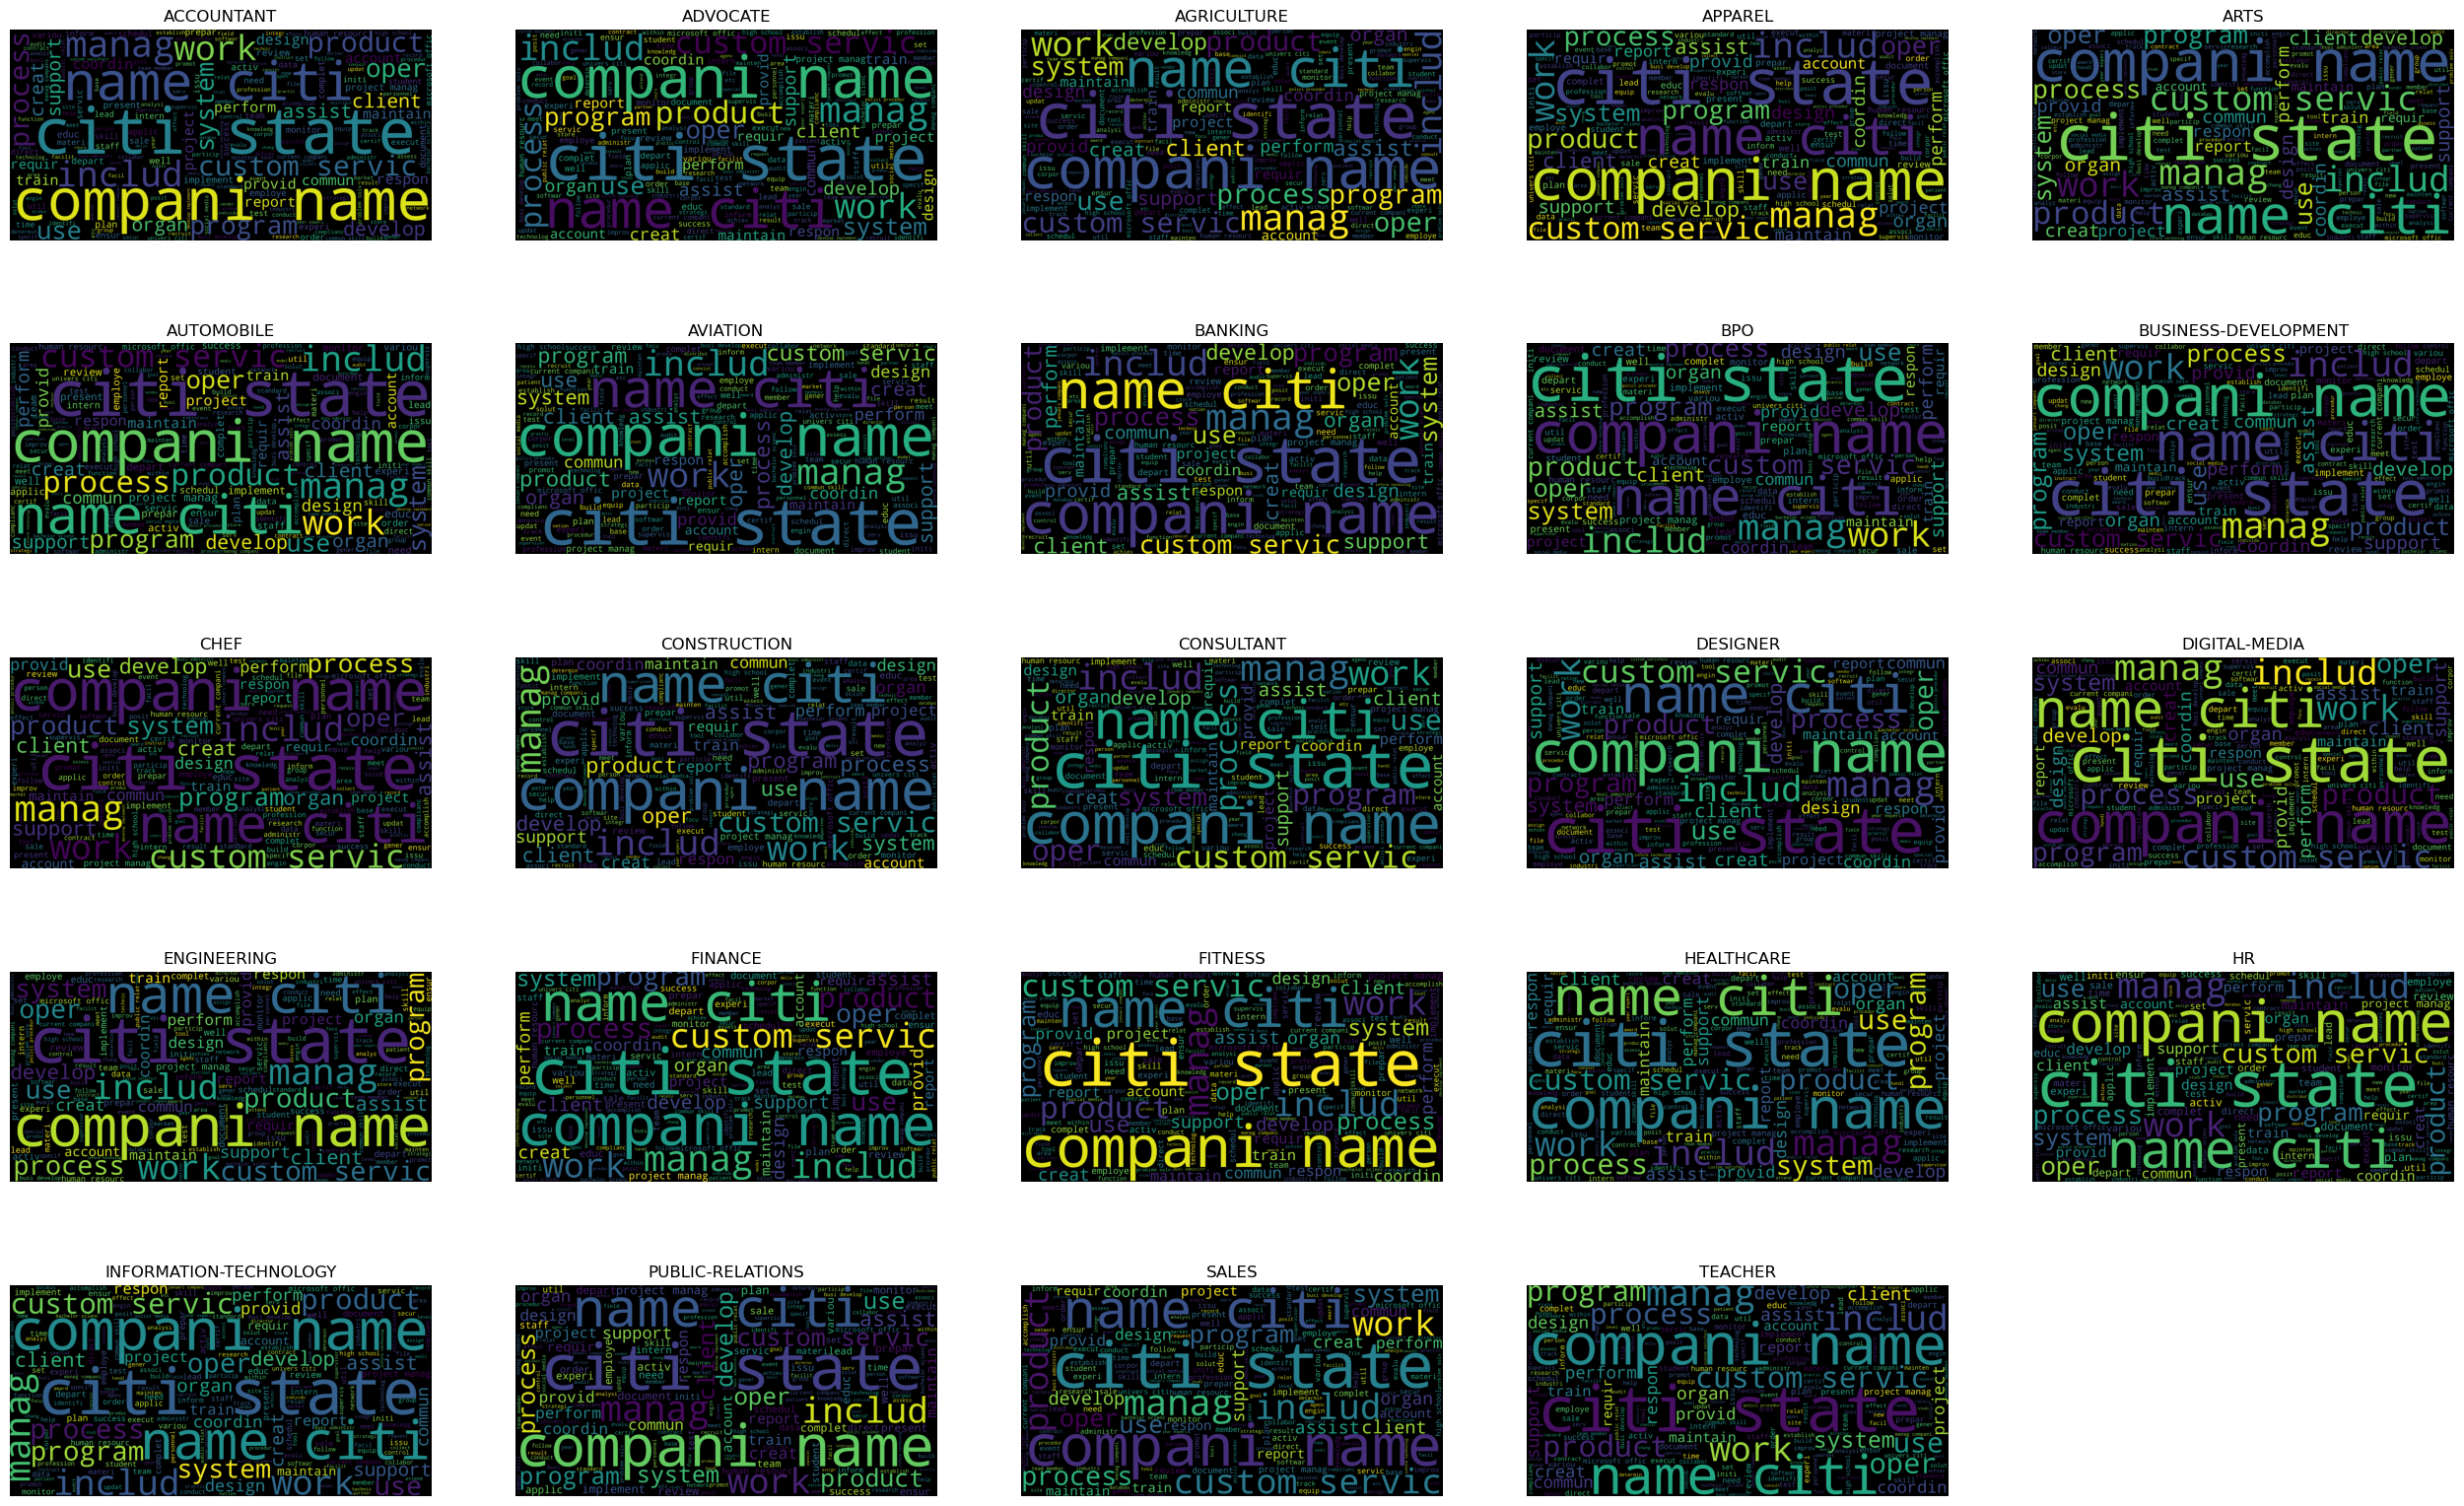

In [28]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

We see that this word cloud contains some words with huge numbers, but maybe it's not important for our training model. It may reduce our accuracy and increase losses when I run the model. So if we remove this word, may it be beneficial?

In [29]:
# try to remove extra word which are note important.
def remove_extra_word(text):
    
    extra_word=['compani', 'name', 'citi', 'state', 'work', 'manag'] # extra words
    words = text.split()  # Split the text into words
    
    # Filter out the extra words
    filter_word = [word for word in words if word not in extra_word]
    
    filter_text = ' '.join(filter_word)
    
    return filter_text


# apply resume_data['Cleaned_Resume']

resume_data['Cleaned_Resume']=resume_data['Cleaned_Resume'].apply(lambda x:remove_extra_word(x))

After cleaning the extra word, let's see how much well our word clouded.

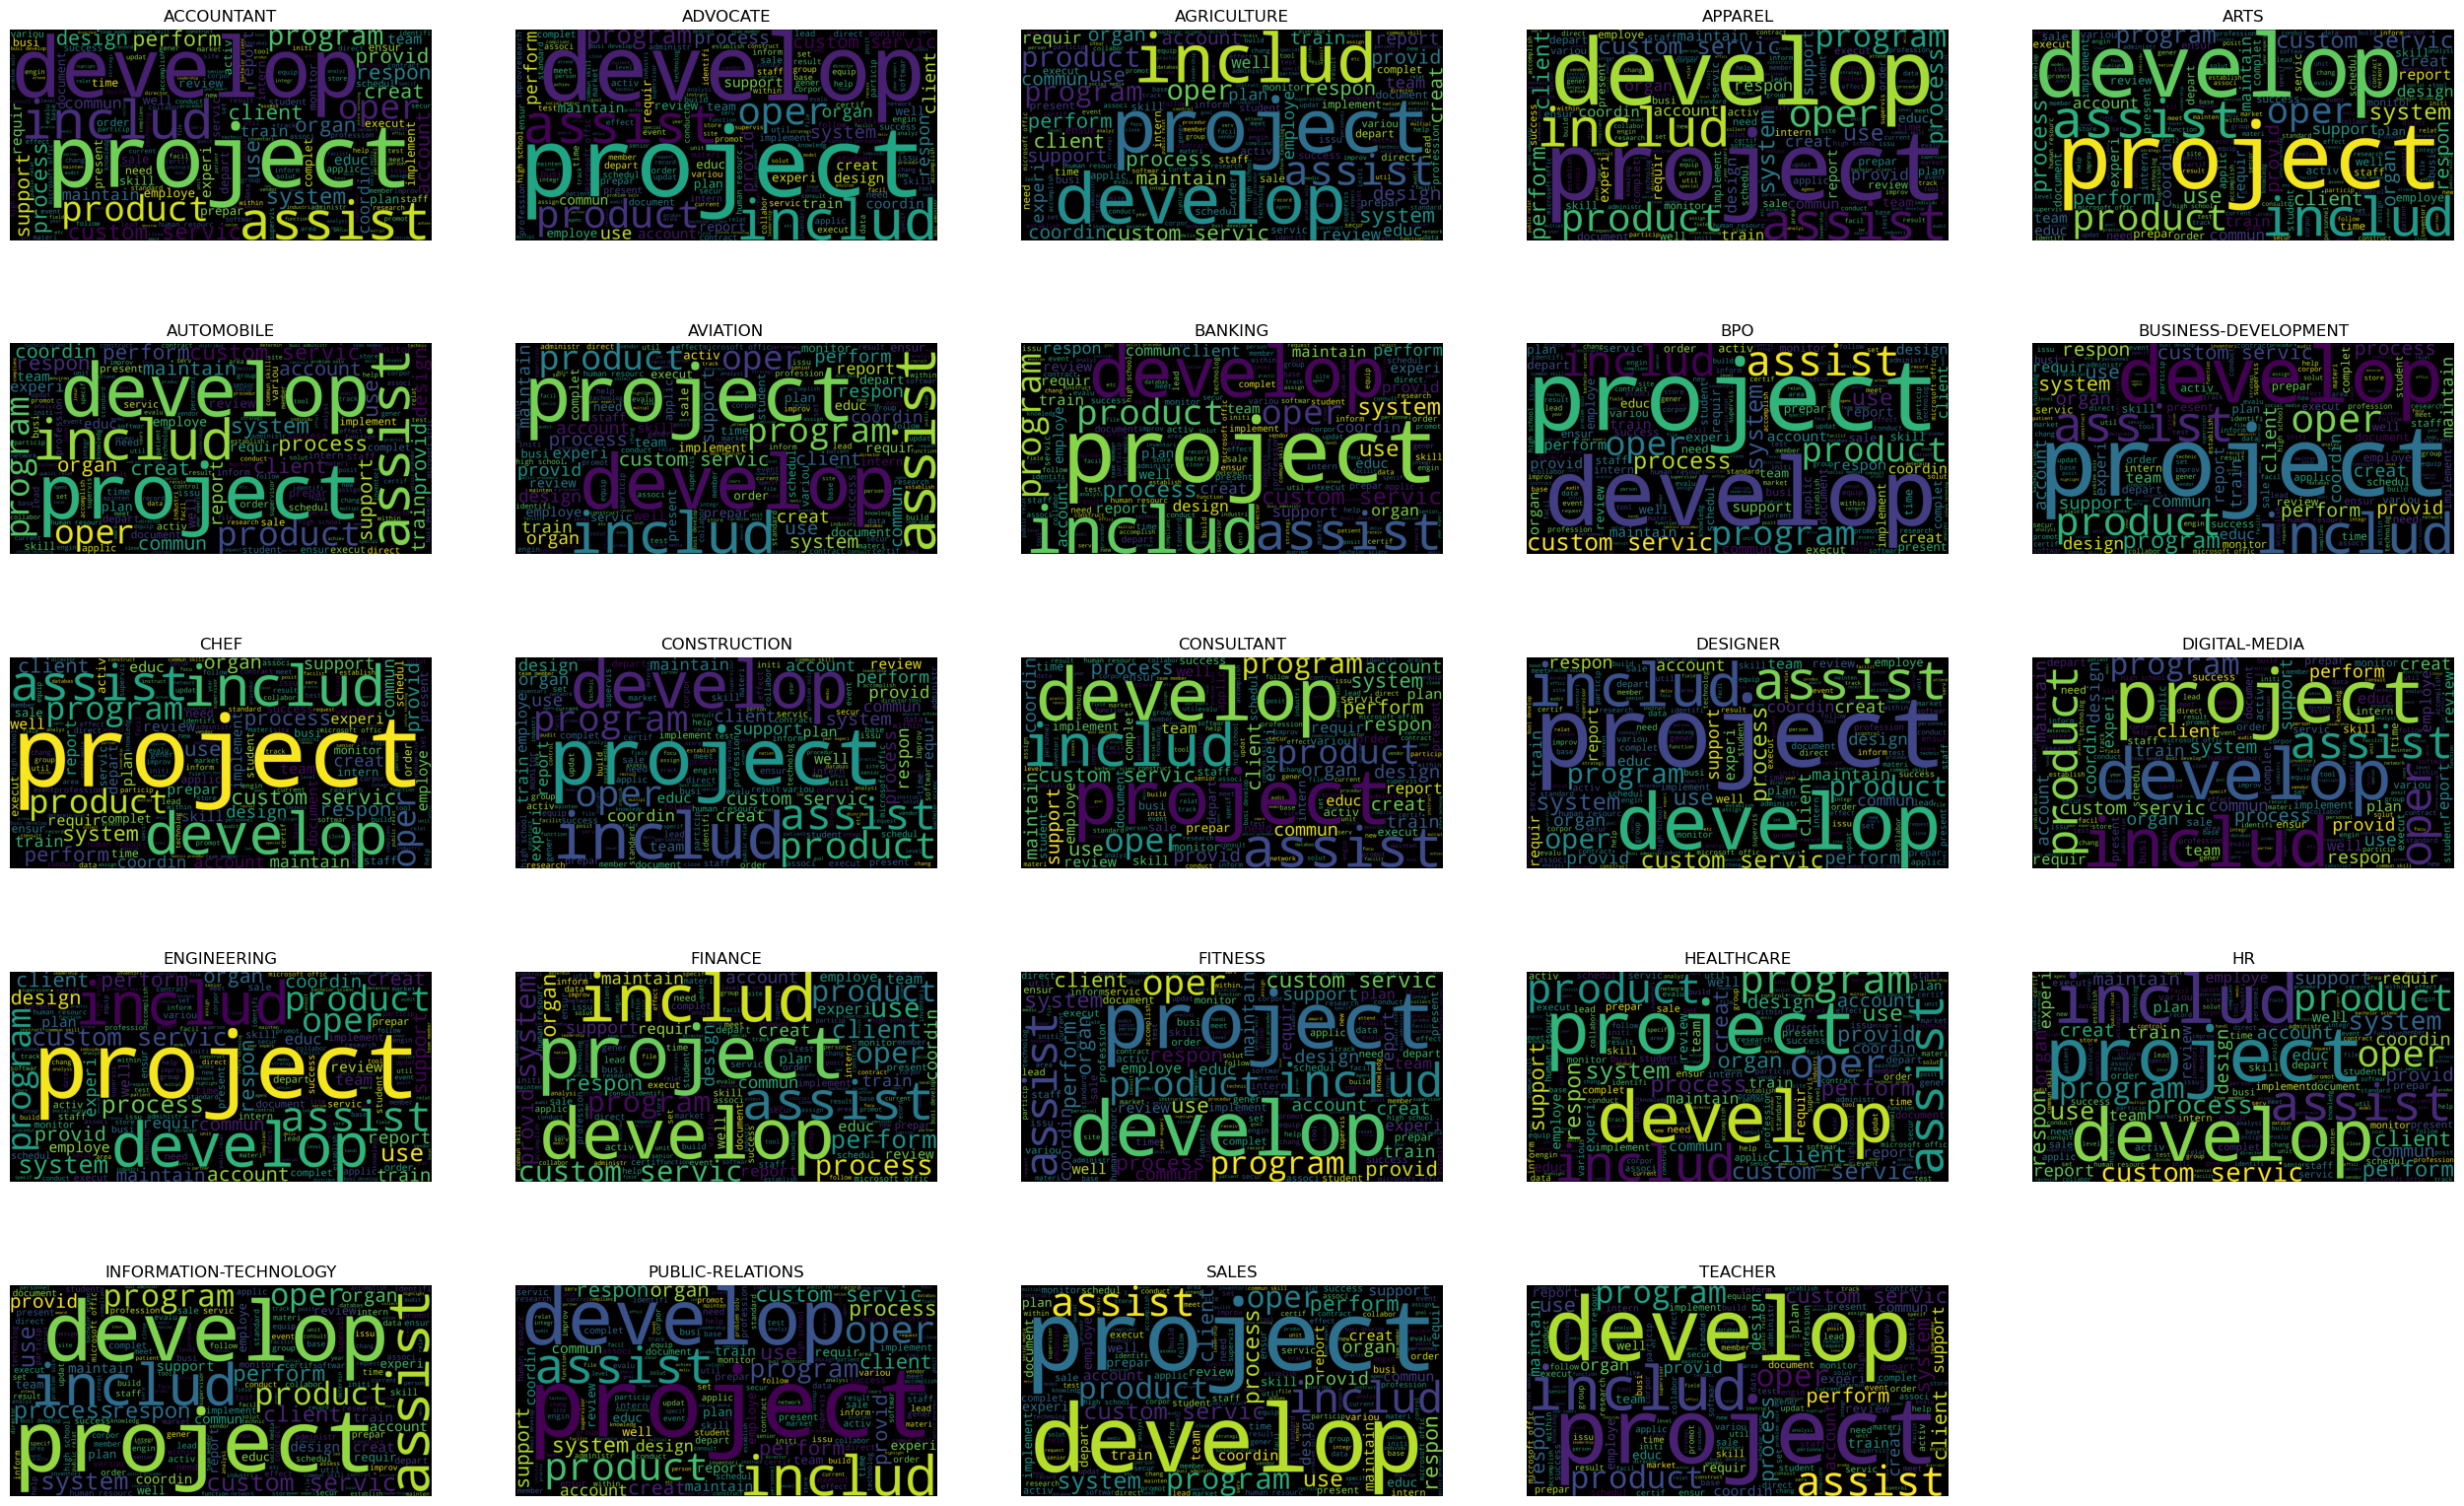

In [30]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

YES!!!, It's good. Here we see some words highlighted that are co-related to our category values.

## Preprocessing and Encoding
In the Encoding section, we employed Label Encoding to transform the categorical values in the 'Category' column into numerical representations. This facilitates the incorporation of categorical data into machine learning models.

In the text analysis section, we performed vectorization on the textual data using techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) and Word2Vec. Vectorization converts the textual content into numerical vectors, enabling computational analysis and modeling on text-based data.

In [31]:
#now label encoding of Category columns

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [32]:
# encoding and transfrom
resume_data['Category']=encoder.fit_transform(resume_data['Category'])

In [33]:
#now check is it work or not?
resume_data.head()

ID  Category                                     Cleaned_Resume
1443  16066857        10  senior execut chef execut profil seek employ e...
56    52979663        19  senior hr highlight safeti managementemploye e...
1131  15281412        12  consult summari transit applic develop secur p...
2472  16279537         6  supervisori logist specialist summari target f...
1710  24647794        15  engin intern profil profici entri level electr...

YES!!!!!!!, It's work. Congratulations Everyone, We've done our first encoding process

In [34]:
# Now check all category value which are encoded by LabelEncoding
resume_data.Category.unique()

array([10, 19, 12,  6, 15,  7,  9,  1, 16, 14, 11, 18, 13,  2,  4, 17, 23,
       21,  3, 20,  0, 22,  8,  5])

## Dataset Splitting

In [36]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(resume_data['Cleaned_Resume'], resume_data['Category'], test_size=0.15, random_state=42, stratify=resume_data['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_valid.shape)

Train data size: (1793,)
Validation data size: (317,)


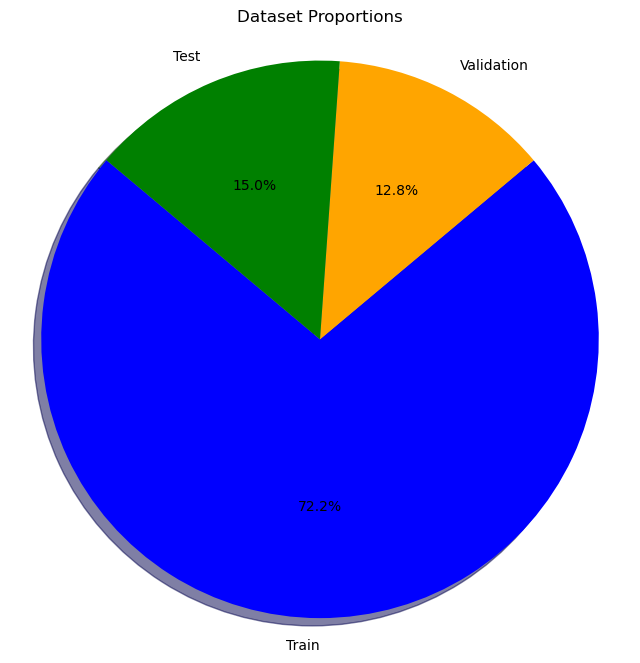

In [37]:
# create pie chart for all training , validation and testing data.

# Calculate dataset sizes
train_size = X_train.shape[0]
val_size = X_valid.shape[0]
test_size=resume_test_data.shape[0]  # our test data, which is separate from the full data

# Labels for the pie chart
labels = ['Train', 'Validation', 'Test']

# Sizes of the pie slices
sizes = [train_size, val_size, test_size]

# Colors for each slice
colors = ['blue', 'orange', 'green']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, shadow=True, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Proportions')
plt.axis('equal')  
plt.show()

Now our data set is separated into training, validation, and testing with respect to 72.2%, 12.8%, and 15%.

### Vectorization of TF-IDF
Now, we are vectorization the "Cleaned_resume" column text using TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF is a numerical representation used in natural language processing and information retrieval to measure the importance of a word within a document relative to a collection of documents. It combines the frequency of a term (word) in a document (TF) with its rarity across the entire document collection (IDF).

In [38]:
#import TfidfVectorizer for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
# create tf-idf model. and set te max_fatures 800.
tfidf=TfidfVectorizer(stop_words='english',max_features=800)

In [40]:
#fit and transfrom all dataset
tfidf_train_vectors = tfidf.fit_transform(X_train)
tfidf_valid_vectors =tfidf.transform(X_valid)

In [41]:
tfidf_train_vectors.shape

(1793, 800)

In [42]:
# check vocabulary 
#tfidf.vocabulary_
# extracting feature names
tfidf.get_feature_names_out()

array(['abil', 'abl', 'academ', 'accept', 'access', 'accomplish',
       'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit',
       'act', 'action', 'activ', 'ad', 'adapt', 'addit', 'address',
       'adher', 'adjust', 'administ', 'administr', 'adob', 'advanc',
       'advertis', 'advis', 'advoc', 'affili', 'agenc', 'agent',
       'agreement', 'aid', 'air', 'aircraft', 'align', 'allow', 'america',
       'american', 'analysi', 'analyst', 'analyt', 'analyz', 'annual',
       'answer', 'appli', 'applic', 'appoint', 'approach', 'appropri',
       'approv', 'april', 'architectur', 'area', 'armi', 'arrang', 'art',
       'aspect', 'assembl', 'assess', 'asset', 'assign', 'assist',
       'associ', 'assur', 'attend', 'attent', 'audit', 'august', 'author',
       'autom', 'avail', 'averag', 'aviat', 'awar', 'award', 'bachelor',
       'background', 'balanc', 'bank', 'base', 'basi', 'basic',
       'behavior', 'benefit', 'best', 'board', 'book', 'branch', 'brand',
       'budget', 

## Machine Learning Classifier
In this study, We use to Basic Classifier which are related to work with Text such as (Random Forest classifier,Logistic Regresssion,K-Nearest Neighbors,Naive Bayes and Support Vector Machine) and also used advanced Technique such as (Artificial Neural Network).

In [43]:
# store all model and accuracy values
accuracy_lis=[]
model_lis=[]

### Random Forest classifier

In [44]:
#import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
RF = RandomForestClassifier()

RF.fit(tfidf_train_vectors,y_train)
# Predict on validation data
y_val_pred = RF.predict(tfidf_valid_vectors)


# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_valid, y_val_pred))

accuracy=accuracy_score(y_valid, y_val_pred)
print("Accuracy is : ", accuracy)

# store info
model_lis.append("Random Forest Classifier")
accuracy_lis.append(accuracy*100)

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.71      0.80      0.75        15
           2       0.00      0.00      0.00         8
           3       0.67      0.67      0.67        12
           4       0.40      0.15      0.22        13
           5       1.00      0.20      0.33         5
           6       0.85      0.73      0.79        15
           7       0.64      0.47      0.54        15
           8       0.00      0.00      0.00         3
           9       0.56      0.67      0.61        15
          10       0.71      1.00      0.83        15
          11       0.69      0.79      0.73        14
          12       0.67      0.53      0.59        15
          13       0.77      0.71      0.74        14
          14       0.88      0.58      0.70        12
          15       0.79      0.73      0.76        15
          16       0.56      0.60      

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Logistic Regresssion

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
# lR

LR = LogisticRegression()

LR.fit(tfidf_train_vectors,y_train)
# Predict on validation data
y_val_pred = LR.predict(tfidf_valid_vectors)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_valid, y_val_pred))

print("Accuracy is : ", accuracy_score(y_valid, y_val_pred))

# store info
model_lis.append("Logistic Regression")
accuracy_lis.append(accuracy_score(y_valid, y_val_pred)*100)

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.63      0.80      0.71        15
           1       0.47      0.60      0.53        15
           2       0.00      0.00      0.00         8
           3       0.73      0.67      0.70        12
           4       0.45      0.38      0.42        13
           5       1.00      0.20      0.33         5
           6       0.79      0.73      0.76        15
           7       0.70      0.47      0.56        15
           8       0.00      0.00      0.00         3
           9       0.62      0.67      0.65        15
          10       0.79      1.00      0.88        15
          11       0.80      0.57      0.67        14
          12       0.43      0.20      0.27        15
          13       0.67      0.71      0.69        14
          14       0.75      0.50      0.60        12
          15       0.62      0.67      0.65        15
          16       0.53      0.53      

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



If I look at this classification report, then we see some class labels get zero or very poor values. That means this type of categorized resume is not well fit and trained. Let's go to another classifier, get any improvement or not?



### K-Nearest Neighbors

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
# Initialize KNN classifier
k = 24 # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the KNN classifier
knn_classifier.fit(tfidf_train_vectors,y_train)

# Predict on validation data
y_val_pred = knn_classifier.predict(tfidf_valid_vectors)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_valid, y_val_pred))

print("Accuracy is : ", accuracy_score(y_valid, y_val_pred))

# store info
model_lis.append("K Nearest Neighbors")
accuracy_lis.append(accuracy_score(y_valid, y_val_pred)*100)

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.46      0.80      0.59        15
           1       0.37      0.47      0.41        15
           2       0.00      0.00      0.00         8
           3       0.57      0.33      0.42        12
           4       0.50      0.15      0.24        13
           5       0.00      0.00      0.00         5
           6       0.80      0.53      0.64        15
           7       0.67      0.40      0.50        15
           8       0.00      0.00      0.00         3
           9       0.50      0.67      0.57        15
          10       0.75      1.00      0.86        15
          11       0.80      0.57      0.67        14
          12       0.50      0.07      0.12        15
          13       0.69      0.64      0.67        14
          14       0.88      0.58      0.70        12
          15       0.56      0.67      0.61        15
          16       0.56      0.33      

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

If I look at this classification report, then we see some class labels get zero or very poor values. That means this type of categorized resume is not well fit and trained. Let's go to another classifier, get any improvement or not?



### Naive Bayes
Naive Bayes is highly effective for text analysis, It's popular for tasks like topic categorization due to its efficiency and suitability for text classification. It excels when dealing with high-dimensional text data and offers interpretable results.

In [50]:
from sklearn.naive_bayes import MultinomialNB

In [51]:
# Initialize NB classifier
nb_classifier = MultinomialNB()

# Train the KNN classifier
nb_classifier.fit(tfidf_train_vectors,y_train)

# Predict on validation data
y_val_pred = nb_classifier.predict(tfidf_valid_vectors)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_valid, y_val_pred))

print("Accuracy is : ", accuracy_score(y_valid, y_val_pred))

# store info
model_lis.append("Naive Bayes")
accuracy_lis.append(accuracy_score(y_valid, y_val_pred)*100)

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.50      0.80      0.62        15
           1       0.43      0.60      0.50        15
           2       0.00      0.00      0.00         8
           3       1.00      0.25      0.40        12
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00         5
           6       0.69      0.60      0.64        15
           7       0.57      0.53      0.55        15
           8       0.00      0.00      0.00         3
           9       0.48      0.73      0.58        15
          10       0.75      1.00      0.86        15
          11       0.80      0.57      0.67        14
          12       0.00      0.00      0.00        15
          13       0.82      0.64      0.72        14
          14       0.86      0.50      0.63        12
          15       0.58      0.73      0.65        15
          16       0.40      0.27      

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



If I look at this classification report, then we see some class labels get zero or very poor values. That means this type of categorized resume is not well fit and trained. Let's go to another classifier, get any improvement or not?


### Support Vector Machine
SVMs (Support Vector Machines) are powerful for text analysis, handling high-dimensional data and finding optimal class separation.

In [52]:
from sklearn.svm import SVC

# Initialize SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(tfidf_train_vectors,y_train)

# Predict on validation data
y_val_pred = svm_classifier.predict(tfidf_valid_vectors)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_valid, y_val_pred))

print("Accuracy is : ", accuracy_score(y_valid, y_val_pred))

# store info
model_lis.append("Support Vector Machine")
accuracy_lis.append(accuracy_score(y_valid, y_val_pred)*100)

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.45      0.67      0.54        15
           2       0.00      0.00      0.00         8
           3       0.64      0.58      0.61        12
           4       0.44      0.54      0.48        13
           5       1.00      0.20      0.33         5
           6       0.85      0.73      0.79        15
           7       0.54      0.47      0.50        15
           8       0.00      0.00      0.00         3
           9       0.61      0.73      0.67        15
          10       0.88      0.93      0.90        15
          11       0.89      0.57      0.70        14
          12       0.36      0.27      0.31        15
          13       0.73      0.79      0.76        14
          14       0.75      0.50      0.60        12
          15       0.67      0.67      0.67        15
          16       0.69      0.60      

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/radheyruparel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Also, the same problem in some classes is getting precision, recall, and f1 score value zero. if we look at the category name (2,5,8) or (AGRICULTURE, AUTOMOBILE, BPO) .

### Deep Learning Approach
Artificial Neural Networks (ANNs) are commonly applied to process and analyze text data by transforming textual input into numerical representations, enabling tasks like sentiment analysis, text generation, and language translation.

In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Convert sparse matrices to dense arrays
tfidf_train_arrays = tfidf_train_vectors.toarray()
tfidf_valid_arrays = tfidf_valid_vectors.toarray()

# Build a simple neural network model
num_classes = 24

y_train_label = to_categorical(y_train, num_classes=num_classes)
y_valid_label = to_categorical(y_valid, num_classes=num_classes)
# Build a more complex neural network model
model = Sequential()
model.add(Dense(1000, input_dim=tfidf_train_arrays.shape[1]))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(tfidf_train_arrays, y_train_label, epochs=50, batch_size=32, validation_data=(tfidf_valid_arrays, y_valid_label))

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(tfidf_valid_arrays, y_valid_label)
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")

# store info
model_lis.append("Artificial Neural Network")
accuracy_lis.append(accuracy_score(y_valid, y_val_pred)*100)

#### check training accuracy and validation accuracy and traning loss and validation loss

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Summarization of the models and accuracy

In [ ]:
# Create a DataFrame
accuracy_data = pd.DataFrame({'model': model_lis, 'accuracy': accuracy_lis})

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(accuracy_data['model'], accuracy_data['accuracy'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.title('Overview of the models and accuracy')
plt.show()

In [ ]:
accuracy_data

Here wee see , Random Forest Classifier model are performed much better than all others

**Here we see, a big unexpected problem. In this dataset, there are 24 class labels. which handles more difficult and complex work. When I trained the dataset there were some class label data that were less than our total categorization types. That's why some categories do not well fit in our model which is why our model accuracy is downgraded. If we see precision, recall, and f1-score table. Then we clearly understand some classes get zero. because maybe these types of resumes do not fit well or are very small. Overall this explanation we can tell that the comparison of all models is well-worked. but class label data are less about that why our model gets this type of accuracy.**

### Pickle File Generator
In future , if we used this trained model are any others preferences. We will create best_classifier and word2ve/tfidf pickle file for our script.

In [ ]:
# prediction new resume
import pickle
pickle.dump(tfidf,open('tfidf.pkl', 'wb'))
pickle.dump(RF,open('best_clf.pkl', 'wb'))

In [ ]:
# Create a dictionary mapping category names to encoded labels
category_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [ ]:
# this is just for our script.py
category_mapping 